##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with an LSTM

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c08_forecasting_with_lstm.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c08_forecasting_with_lstm.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [19]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

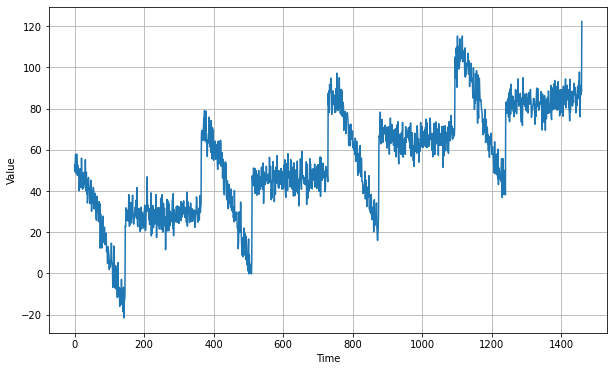

In [20]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [21]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [22]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [23]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

## LSTM RNN Forecasting

In [54]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 50))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=5e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 3s 8ms/step - loss: 45.9512 - mae: 46.4500 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 7ms/step - loss: 42.0919 - mae: 42.5899 - lr: 1.0471e-08
Epoch 3/100
33/33 [==============================] - 0s 7ms/step - loss: 38.4129 - mae: 38.9104 - lr: 1.0965e-08
Epoch 4/100
33/33 [==============================] - 0s 7ms/step - loss: 34.9859 - mae: 35.4826 - lr: 1.1482e-08
Epoch 5/100
33/33 [==============================] - 0s 7ms/step - loss: 32.0817 - mae: 32.5792 - lr: 1.2023e-08
Epoch 6/100
33/33 [==============================] - 0s 8ms/step - loss: 29.8371 - mae: 30.3308 - lr: 1.2589e-08
Epoch 7/100
33/33 [==============================] - 0s 7ms/step - loss: 28.1615 - mae: 28.6586 - lr: 1.3183e-08
Epoch 8/100
33/33 [==============================] - 0s 7ms/step - loss: 26.8216 - mae: 27.3187 - lr: 1.3804e-08
Epoch 9/100
33/33 [==============================] - 0s 7ms/step - loss: 25.6868 - mae: 26.1835 

(1e-08, 0.0001, 0.0, 30.0)

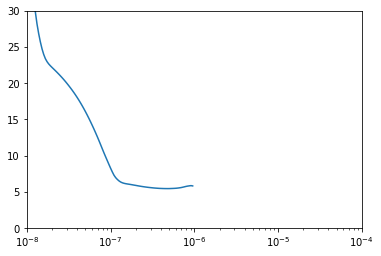

In [55]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [81]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu", 
                        input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200)
])
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 6s 52ms/step - loss: 23.9686 - mae: 24.4654 - val_loss: 16.7785 - val_mae: 17.2683
Epoch 2/500
33/33 [==============================] - 1s 23ms/step - loss: 14.5079 - mae: 14.9997 - val_loss: 16.0313 - val_mae: 16.5238
Epoch 3/500
33/33 [==============================] - 0s 11ms/step - loss: 13.3612 - mae: 13.8536 - val_loss: 12.1239 - val_mae: 12.6190
Epoch 4/500
33/33 [==============================] - 1s 19ms/step - loss: 11.7624 - mae: 12.2553 - val_loss: 12.5401 - val_mae: 13.0332
Epoch 5/500
33/33 [==============================] - 0s 11ms/step - loss: 10.2573 - mae: 10.7500 - val_loss: 10.2906 - val_mae: 10.7854
Epoch 6/500
33/33 [==============================] - 0s 11ms/step - loss: 10.4029 - mae: 10.8931 - val_loss: 9.6725 - val_mae: 10.1611
Epoch 7/500
33/33 [==============================] - 0s 11ms/step - loss: 8.8345 - mae: 9.3188 - val_loss: 9.1794 - val_mae: 9.6703
Epoch 8/500
33/33 [==============================] - 

In [82]:
model = keras.models.load_model("my_checkpoint.h5")

In [83]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 1s 689ms/step


In [84]:
rnn_forecast.shape

(461,)

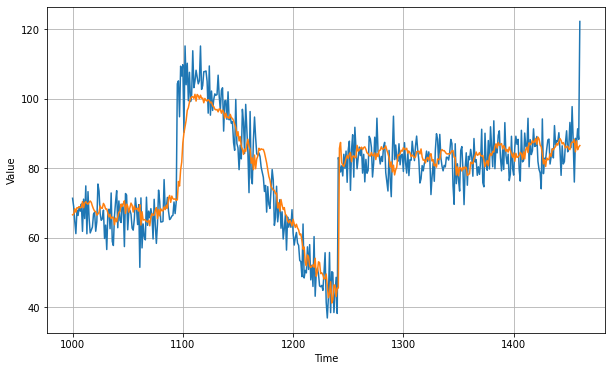

In [85]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [86]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.106009